In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([3])


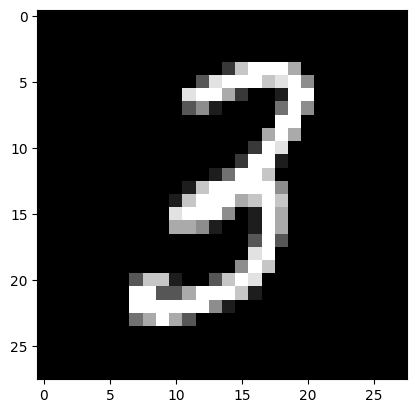

In [2]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
# mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

torch.Size([1, 1, 28, 28]) tensor([5])


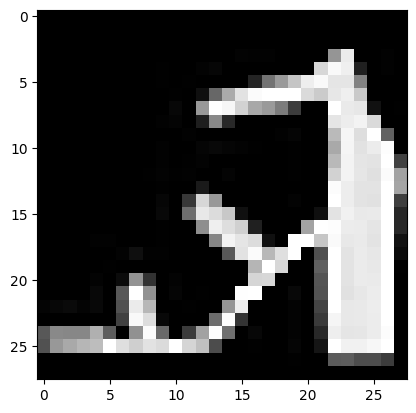

In [3]:
# load fashion mnist
download = False
dataset_class = datasets.FashionMNIST
fashion_mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# fashion_mnist_transform.append(transforms.Lambda(lambda x: x + 1e-6))

dataset_transform = transforms.Compose(fashion_mnist_transform)
fashion_mnist_train = dataset_class('data/FashionMNIST', train=True, download=download, transform=dataset_transform)
fashion_mnist_test = dataset_class('data/FashionMNIST', train=False, download=download, transform=dataset_transform)

fashion_mnist_train_loader = DataLoader(fashion_mnist_train, batch_size=1, shuffle=True)
fashion_mnist_test_loader = DataLoader(fashion_mnist_test, batch_size=1, shuffle=True)

# test the dataloader

for i, (data, target) in enumerate(fashion_mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break


torch.Size([1, 3, 32, 32]) tensor([7])
tensor([[[[0.1098, 0.1765, 0.1569,  ..., 0.1686, 0.2275, 0.1843],
          [0.0980, 0.1725, 0.1137,  ..., 0.1804, 0.1922, 0.1216],
          [0.1569, 0.2196, 0.1686,  ..., 0.1725, 0.1725, 0.1569],
          ...,
          [0.5804, 0.5608, 0.5647,  ..., 0.6000, 0.6196, 0.6196],
          [0.5961, 0.5922, 0.5961,  ..., 0.6392, 0.6392, 0.6275],
          [0.5804, 0.5725, 0.5804,  ..., 0.6431, 0.6549, 0.6431]],

         [[0.1294, 0.1922, 0.1608,  ..., 0.1922, 0.2471, 0.1961],
          [0.1059, 0.1961, 0.1412,  ..., 0.1843, 0.1922, 0.1137],
          [0.1686, 0.2510, 0.2078,  ..., 0.1529, 0.1569, 0.1412],
          ...,
          [0.5961, 0.5765, 0.5843,  ..., 0.6039, 0.6235, 0.6275],
          [0.5922, 0.6000, 0.6078,  ..., 0.6353, 0.6431, 0.6275],
          [0.5686, 0.5725, 0.5882,  ..., 0.6353, 0.6471, 0.6353]],

         [[0.0431, 0.0784, 0.0863,  ..., 0.0902, 0.1137, 0.0667],
          [0.0314, 0.0745, 0.0471,  ..., 0.0902, 0.0902, 0.0235],
   

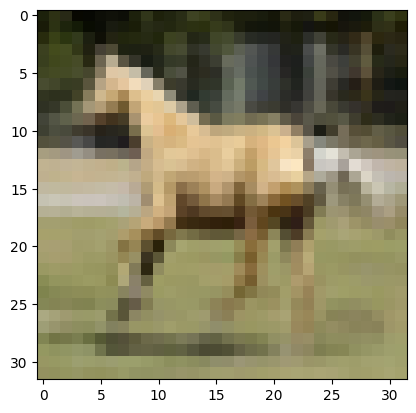

In [4]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# cifar10_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=dataset_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=dataset_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    plt.imshow(data[0].permute(1, 2, 0).numpy())
    plt.show()
    break



## Multinode Prediction
- Use loss_fn_mode=0

In [6]:
class CobwebNNTreeLayer(nn.Module):
    def __init__(self, n_hidden, n_cluster, branch_factor=2, n_classes=10):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_cluster = n_cluster
        self.branch_factor = branch_factor
        self.n_classes = n_classes

        self.l_probs = nn.Linear(n_hidden, n_cluster)
        
        self.classifier_w = nn.Parameter(torch.rand(2*n_cluster, n_hidden, n_classes))
        self.classifier_b = nn.Parameter(torch.rand(2*n_cluster, n_classes))

        self.classifier = nn.Linear(n_hidden, n_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, z):
        '''
        z: parent probs in log-space. Shape: (batch_size, n_cluster)
        x: input data. Shape: (batch_size, n_hidden)
        '''
        B = x.size(0)

        x_l_probs = self.l_probs(x) # (B, n_cluster)
        x_l_probs = self.sigmoid(x_l_probs)
        x_r_probs = 1 - x_l_probs
        x_probs = torch.cat([x_l_probs, x_r_probs], dim=1) # shape: (B, 2 * n_cluster)

        # chain with parent probs
        z_l = z + torch.log(x_l_probs + 1e-5)
        z_r = z + torch.log(x_r_probs + 1e-5)
        z = torch.cat([z_l, z_r], dim=1) # shape: (B, 2 * n_cluster)

        weighted_x_l = (z_l.unsqueeze(2) + torch.log(x).unsqueeze(1)) # shape: (B, n_cluster, n_hidden)
        weighted_x_r = (z_r.unsqueeze(2) + torch.log(x).unsqueeze(1))
        weighted_x = torch.cat([torch.exp(weighted_x_l), torch.exp(weighted_x_r)], dim=1) # shape: (B, 2 * n_cluster, n_hidden)

        logits = torch.einsum('bch,chk->bck', weighted_x, self.classifier_w) + self.classifier_b # shape: (B, 2 * n_cluster, n_classes)
        # logits = self.classifier(weighted_x) # shape: (B, 2 * n_cluster, n_classes)

        return logits, z, x_probs
    
class CobwebNNTree(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, n_classes=10, loss_fn_mode=0):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.n_classes = n_classes
        self.loss_fn_mode = loss_fn_mode

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor**i, branch_factor, n_classes) for i in range(0, n_layers)]
        )
        
        if self.loss_fn_mode == 1:
            self.CorssEntropyLoss = nn.CrossEntropyLoss(reduction='none')
        else:
            self.CorssEntropyLoss = nn.CrossEntropyLoss()

    def forward(self, x, y=None):
        x = x.view(-1, self.n_hidden)
        B = x.size(0)

        z = torch.zeros(B, 1).to(x.device)

        layer_logits = []
        layer_z = []
        layer_x_probs = []
        for layer in self.layers:
            logits, z, x_prob = layer(x, z)
            layer_logits.append(logits)
            layer_z.append(z)
            layer_x_probs.append(x_prob)

        loss = None
        logits = None
        # do loss computations
        if self.loss_fn_mode == 0:
            # FIrst loss, sum[CE[p(c|x)p(y|c), y]]
            weighted_logits = []
            for logits, z, x_prob in zip(layer_logits, layer_z, layer_x_probs):
                logits = torch.exp(z).unsqueeze(2) * logits # shape: (B, 2 * n_cluster, n_classes)
                weighted_logits.append(logits.sum(dim=1))
            weighted_logits = torch.stack(weighted_logits, dim=1).sum(dim=1) # shape: (B, n_classes)
            logits = weighted_logits
            if y is not None:
                loss = self.CorssEntropyLoss(weighted_logits, y)

        elif self.loss_fn_mode == 1:
            # second loss, sum[p(c|x) CE[p(y|c), y]]
            if y is not None:
                losses = []
                for logits, z, x_prob in zip(layer_logits, layer_z, layer_x_probs):
                    cluster_loss = self.CorssEntropyLoss(logits.permute(0, 2, 1), y.unsqueeze(1).repeat(1, logits.size(1))) # shape: (B, 2 * n_cluster)
                    cluster_loss = (torch.exp(z) * cluster_loss)
                    # print(cluster_loss.shape)
                    # cluster_loss = self.CorssEntropyLoss(logits.view(-1, self.n_classes), y.repeat(1, logits.size(1)).view(-1))
                    losses.append(cluster_loss.sum(dim=1))
                    # print(losses[-1], losses[-1].shape)
                loss = torch.stack(losses, dim=1).mean(dim=1).mean(dim=0)
            # print(loss, loss.shape)

        return untils.ModelOutput(loss=loss, logits=logits, debug_info={'layer_logits': layer_logits})



Epoch 12/12: 100%|██████████| 196/196 [00:13<00:00, 14.01it/s, loss=1.84]


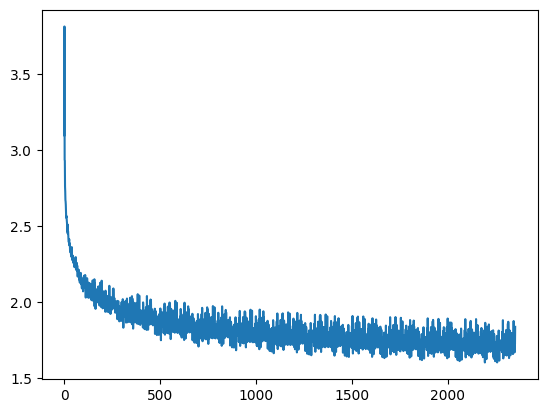

In [ ]:
n_layers = 8
model = CobwebNNTree(n_layers=n_layers, branch_factor=2, n_hidden=3*32*32, n_classes=10, loss_fn_mode=1)
# model = CobwebSparse(n_layers=n_layers, branch_factor=2, n_input=64).to('cuda')

model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

untils.train_model(model, cifar10_train, True, optimizer, epochs=12, batch_size=256, show_loss=True, 
                   device='cuda', verbose=False, early_break=False)



- lr=1e3, batch=256, n_layers=8, 12 epochs, gives 97.37%

In [8]:
untils.test_model(model, cifar10_test, device='cuda', batch_size=256)

Accuracy: 0.4379


In [20]:
# test single node prediction
def test_model(model, test_data, device='cuda', batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    labels = []
    layer_argmax = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            outputs = model(x.to(device))
            layer_logits = outputs.debug_info['layer_logits']
            cluster_preds = torch.cat([logits.detach().cpu().argmax(dim=-1) for logits in layer_logits], dim=1)
            layer_argmax.append(cluster_preds)
            labels.extend(y.tolist())

        # concat the predictions of all batches
        layer_argmax = torch.cat(layer_argmax, dim=0) # shape: (N, 2**n_layers)
        labels = torch.tensor(labels).view(-1, 1).repeat(1, layer_argmax.size(1))
        correct = (layer_argmax == labels).sum(dim=0)
        accuracy = correct.float() / len(labels) # shape: (2**n_layers)
        return accuracy
    
accuracy = test_model(model, cifar10_test, device='cuda', batch_size=256)
print(accuracy)

100%|██████████| 40/40 [00:02<00:00, 19.03it/s]

tensor([0.3581, 0.3517, 0.3738, 0.3657, 0.3798, 0.3692, 0.3828, 0.2580, 0.3747,
        0.3822, 0.1000, 0.2884, 0.1000, 0.3775, 0.2319, 0.2121, 0.2440, 0.3838,
        0.0999, 0.2835, 0.1000, 0.1000, 0.2745, 0.1001, 0.2794, 0.1000, 0.1000,
        0.1000, 0.1000, 0.3828, 0.1849, 0.2652, 0.1000, 0.3848, 0.1000, 0.1002,
        0.1000, 0.1000, 0.2825, 0.1000, 0.2538, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1870, 0.1000, 0.2467, 0.1000, 0.1000, 0.2978, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1185, 0.1000, 0.1000, 0.1000, 0.1000, 0.3853, 0.2361,
        0.1000, 0.1000, 0.2987, 0.1000, 0.1002, 0.1000, 0.1000, 0.1000, 0.1000,
        0.3074, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1733, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1162, 0.1000,
        0.1000, 0.1000, 0.1000, 0.2566, 0.1000, 0.2612, 0.1000, 0.2142, 0.1000,
        0.1000, 0.1000, 0.1000, 0.2973, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 

In [21]:
# display a binary tree like structure of accuracy. There is no root and it starts with the first layer (2 nodes)
def display_accuracy(accuracy, n_layers):
    n_nodes = 2 ** n_layers
    for i in range(1, n_layers + 1):
        print(f'Layer {i}')
        for j in range(2 ** i):
            print(f'{accuracy[j]:.2f}', end=' ')
        print()
        accuracy = accuracy[2 ** i:]

display_accuracy(accuracy, n_layers)


Layer 1
0.36 0.35 
Layer 2
0.37 0.37 0.38 0.37 
Layer 3
0.38 0.26 0.37 0.38 0.10 0.29 0.10 0.38 
Layer 4
0.23 0.21 0.24 0.38 0.10 0.28 0.10 0.10 0.27 0.10 0.28 0.10 0.10 0.10 0.10 0.38 
Layer 5
0.18 0.27 0.10 0.38 0.10 0.10 0.10 0.10 0.28 0.10 0.25 0.10 0.10 0.10 0.10 0.10 0.19 0.10 0.25 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.12 0.10 0.10 0.10 0.10 0.39 
Layer 6
0.24 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.31 0.10 0.10 0.10 0.10 0.10 0.17 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.12 0.10 0.10 0.10 0.10 0.26 0.10 0.26 0.10 0.21 0.10 0.10 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.25 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.26 
Layer 7
0.20 0.10 0.10 0.13 0.10 0.10 0.10 0.10 0.10 0.10 0.28 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.16 0.10 0.10 0.10 0.10 0.10 0.10 0.11 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.25 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.1

In [10]:
display_accuracy(accuracy, n_layers)


NameError: name 'display_accuracy' is not defined